In [ ]:
#imports
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
#generate stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-08-10')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.765709
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.038536
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.605175
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.144630
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.061932
...,...,...,...,...,...,...
2020-08-04,443.160004,433.549988,436.529999,438.660004,43267900.0,437.870514
2020-08-05,441.570007,435.589996,437.510010,440.250000,30498000.0,439.457642
2020-08-06,457.649994,439.190002,441.619995,455.609985,50607200.0,454.790009


In [ ]:
#get number of rows and columns in the data set
df.shape

(2165, 6)

Text(0, 0.5, 'Closing Price (USD)')

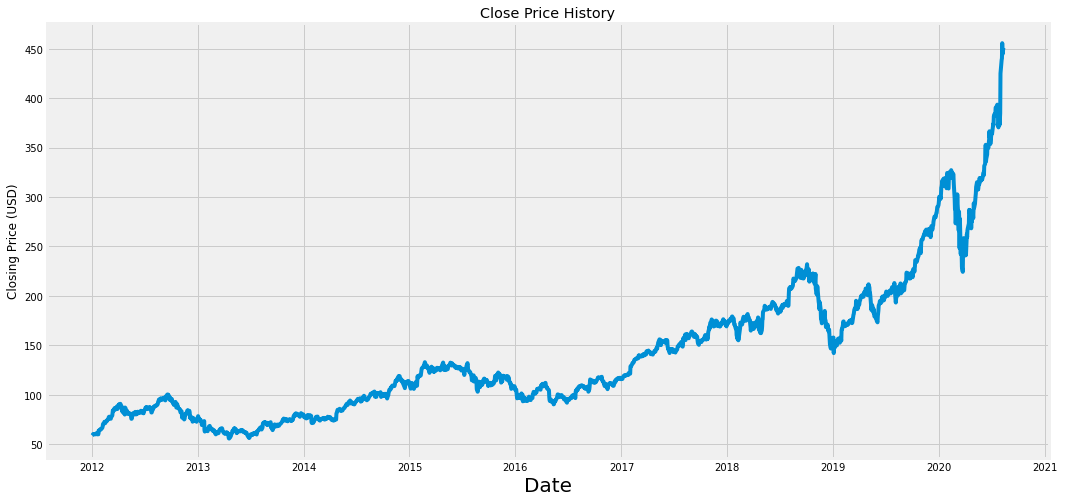

In [ ]:
#Plot closing price graph
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Closing Price (USD)')

In [ ]:
#Create a dataframe with only the 'Close' column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1732

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.00739618],
       [0.00818583],
       [0.00982585],
       ...,
       [1.        ],
       [0.97208751],
       [0.98824476]])

In [ ]:
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i, 0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1672, 60, 1)

In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1672/1672 [==============================] - 38s 23ms/step - loss: 3.4622e-04


In [ ]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2020
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


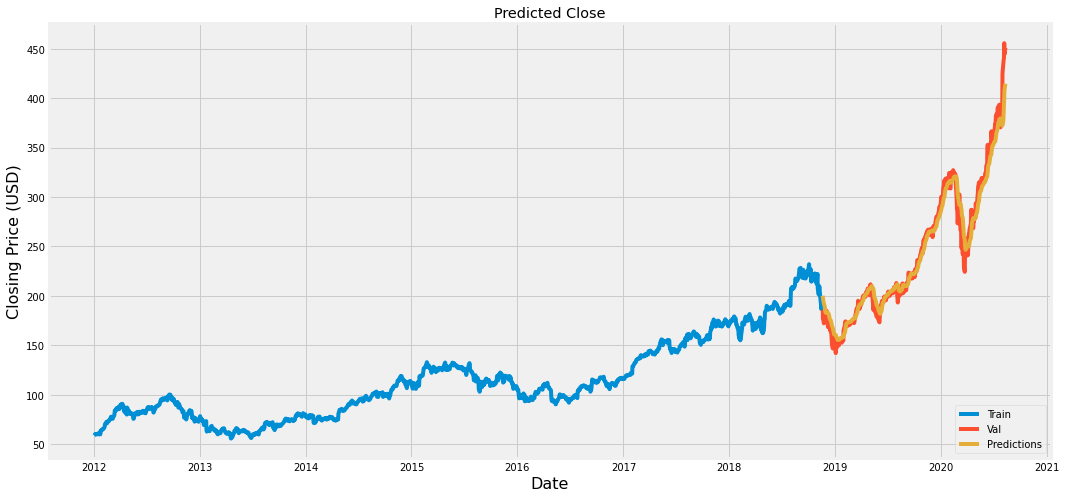

In [ ]:
#Plotting data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#style
plt.figure(figsize=(16,8))
plt.title('Predicted Close')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Closing Price (USD)', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()